# Crop Classification

## Setup
<hr>

In [47]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

from tifffile import TiffFile
from dbfread import DBF
from pandas import DataFrame
from skimage.util import view_as_windows


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
mpl.rc('figure' ,figsize=[12, 12])
mpl.rc('figure', dpi=72)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
np.random.seed(27)

## Load Data
<hr>

In [4]:
def raster_to_numpy_array(filename):
    return np.array(TiffFile(filename).asarray())


full_training_data = raster_to_numpy_array(
    os.path.join("data", "20130824_RE3_3A_Analytic_Champaign_north.tif")
)

training_data_labels = raster_to_numpy_array(
    os.path.join("data", "CDL_2013_Champaign_north.tif")
)


In [5]:
label_mapping = DataFrame(
    iter(
        DBF(os.path.join("data", "CDL_2013_clip_20170525181724_1012622514.tif.vat.dbf"))
    )
)


### Data Metadata

 There should be 5 bands in the imagery data. Because the training data label raster shares the same projection as the imagery data and was resampled from 30m/pixel to 5m/pixel to match it's resolution, they should have the same data.

In [6]:
# Training data has 5 bands
print(full_training_data.shape[2])

# Training data and label have the same shape
print(full_training_data.shape[:2])
print(training_data_labels.shape)


5
(5959, 9425)
(5959, 9425)


The RapidEye product specification I found says the pixel depth is 16 bits, unsigned. Does that match the data?

In [7]:
print(full_training_data.max(axis=(0, 1)))
print(full_training_data.min(axis=(0, 1)))


[35709 35412 31680 24759 24381]
[0 0 0 0 0]


Not sure. These values seem pretty low. Perhaps there are simply no bright colors. It shouldn't be a problem as these values will be normalized anyway. 

What about the label data?

In [8]:
print([training_data_labels.min(), training_data_labels.max()])
print([label_mapping["VALUE"].min(), label_mapping["VALUE"].max()])
print()

print(label_mapping[label_mapping["VALUE"] == 0])
print(label_mapping[label_mapping["CLASS_NAME"] == "Corn"])
print(label_mapping[label_mapping["CLASS_NAME"] == "Soybeans"])


[1, 254]
[0, 254]

   VALUE  CLASS_NAME  RED  GREEN  BLUE  OPACITY
0      0  Background  0.0    0.0   0.0      0.0
   VALUE CLASS_NAME  RED     GREEN  BLUE  OPACITY
1      1       Corn  1.0  0.827451   0.0      1.0
   VALUE CLASS_NAME      RED     GREEN  BLUE  OPACITY
5      5   Soybeans  0.14902  0.439216   0.0      1.0


This checks out. I guess Background is never used as are probably many others. Corn (1) and Soybeans (5) are the important ones.

I'll remove everything else.

In [9]:
simple_training_data_labels = np.where(
    (training_data_labels == 1) | (training_data_labels == 5), training_data_labels, 0
)

np.unique(simple_training_data_labels)

array([0, 1, 5], dtype=uint8)

### Removing Missing Data


It seems like some of the training data imagery is missing from the extent of the labeled data. Note the black around the borders

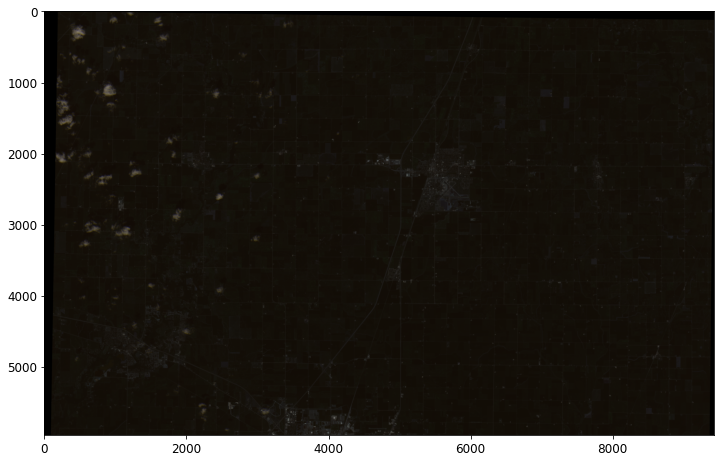

In [43]:
def plt_rgb(data, bit_depth=16):
    rgb = data[:, :, :3]
    plt.imshow(rgb / 2 ** bit_depth)


plt_rgb(full_training_data)
plt.show()


While the labeled data fills the rectange:

In [80]:

colors

array([[0., 0., 0., 0.],
       [1., 2., 3., 4.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [126]:
corn_row = label_mapping[label_mapping["CLASS_NAME"] == "Corn"]
corn_color = (corn_row["RED"], corn_row["GREEN"], corn_row["BLUE"], corn_row["OPACITY"])

soybean_row = label_mapping[label_mapping["CLASS_NAME"] == "Soybeans"]
soybean_color = (
    soybean_row["RED"],
    soybean_row["GREEN"],
    soybean_row["BLUE"],
    soybean_row["OPACITY"],
)


def color_data(X):
    corn_color if X == 1 else soybean_color if (X == 5) else (0, 0, 0, 0)


def plt_labels(data):
    # plt.imshow(color_func(data))
    plt.imshow(data



plt_labels(simple_training_data_labels)
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

If the model is looking for data where it doesn't exist, it will throw off the model. The simplest way to get around this is to crop the data set to remove the areas with missing data.

In [12]:
# A function that takes a row or column of band values (n, 5) and returns the non-empty indices
def get_non_empty_indices(array):
    return np.where(np.any(array > 0, axis=1))[0]


# First non-empty (0,0,0,0,0) pixel in the first row
start_pixel_column = get_non_empty_indices(full_training_data[0])[0]

# Last non-empty pixel in the last row
end_pixel_column = get_non_empty_indices(full_training_data[-1])[-1]

# First non-empty pixel in the end_pixel_column
start_pixel_row = get_non_empty_indices(full_training_data[:, end_pixel_column])[0]

# Last non-empty pixel in the start_pixel_column
end_pixel_row = get_non_empty_indices(full_training_data[:, start_pixel_column])[-1]

print([[start_pixel_row, start_pixel_column], [end_pixel_row, end_pixel_column]])


[[125, 196], [5958, 9363]]


These two points define the new bounding box of the training data. Now to crop:

In [13]:
cropped_training_data = full_training_data[
    start_pixel_row:end_pixel_row, start_pixel_column:end_pixel_column
]
cropped_training_data.shape


(5833, 9167, 5)

Plotting the image again should verify the black areas are no longer inside the study area.

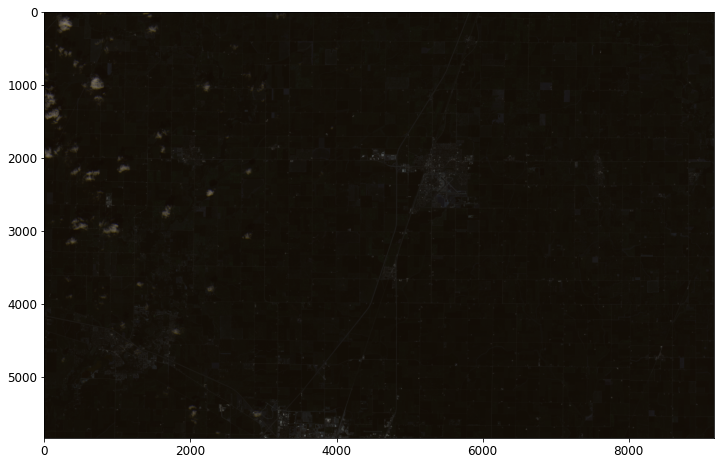

In [44]:
plt_rgb(cropped_training_data)
plt.show()

Now to crop the training data labels with the same coordinates.

In [23]:
cropped_training_data_labels = simple_training_data_labels[
    start_pixel_row:end_pixel_row, start_pixel_column:end_pixel_column
]
cropped_training_data_labels.shape


(5833, 9167)

## Chunking Data
<hr>

Ultimately this is an semantic segmentation problem. The goal is classify each pixel in an image as being either corn, soybean or anything else. We don't care about grouping individual farms, only what crop the pixel is. Convolutional nueral networks are good for any type of computer vision, including semantic segmentation. 

Normally when training a semantic segmentation model, many labeled pictures are used. With this assignment, all I have is one large image and its classification. While it would be nice to train model on the entire image (or at least the non-validation part of it) at once, the backpropagation calculations would probably require way too much memory.

Instead, I'm going to have to break up the data into chunks. Unfortunately this means there will probably be some data loss. Fields and their boundaries might get abitrarily divided which might reduce the effectiveness of the model. I hope to mitigate this by overlapping the chunks of data. Each new chunk will set as its midpoint, the border of the last chunk. That way features that lie on the edge on one chunk will be in the center of the next. 

### Chunk Size

The chunk size will probably have a large effect on the performance and accuracy of the model. It needs to be small enough to fit into memory and keep the model performant, but large enough to pick up on patterns that can identify crops. 

My guess is that the patterns which will be most effective at distinguishing between corn and soybean will be at the subfield scale. At the field-scale (at least from a remote sensing perspective), corn and soybean are mostly the same. The size of corn and soybean fields are not drastically different and their geometry is determined more by geographical, municipal and residential borders than agricultural properties.

This means I can probably keep the chunk size pretty small and still get accurate results. I don't need to have many fields in the same chunk in order for field-level patterns to be recognized because those patterns aren't likely to distinguish between corn and soybean.

In [24]:
chunk_width = 100  # .5 km
chunk_length = 100  # .5 km
number_of_bands = cropped_training_data.shape[2]

# view_as_windows requires the slices and step parameters match the dimension of the passed array,
# so each band is processed separately and then rejoined after
all_training_chunks = np.array(
    [
        view_as_windows(
            cropped_training_data[:, :, band],
            [chunk_width, chunk_length],
            [chunk_width // 2, chunk_length // 2],
        )
        for band in range(number_of_bands)
    ]
)

all_training_chunks = np.moveaxis(all_training_chunks, 0, -1)

all_training_chunks = all_training_chunks.reshape(
    (
        all_training_chunks.shape[0] * all_training_chunks.shape[1],
        100,
        100,
        number_of_bands,
    ),
)


all_training_chunks.shape


(20930, 100, 100, 5)

The shape looks right. A plot of a few of the chunks should verify.

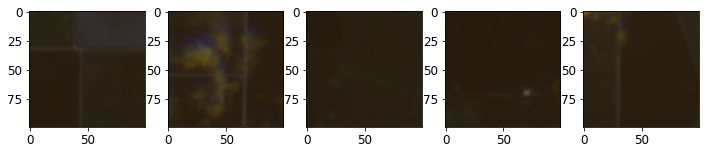

In [45]:
plt.figure()

for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt_rgb(
        all_training_chunks[np.random.randint(0, all_training_chunks.shape[0])],
        bit_depth=15,  # this effectively brings up the brightness, making it easier to discern detail
    )


plt.show()


The pictures don't appear distored and the colors look about the same as the original.

Now to chunk the training data labels.

In [26]:
training_data_labels_chunked = view_as_windows(
    cropped_training_data_labels,
    [chunk_width, chunk_length],
    [chunk_width // 2, chunk_length // 2],
)

training_data_labels_chunked = training_data_labels_chunked.reshape(
    (
        training_data_labels_chunked.shape[0] * training_data_labels_chunked.shape[1],
        100,
        100,
    ),
)

training_data_labels_chunked.shape


(20930, 100, 100)

The training label data has the same number of chunks as the actually training data. This is a good sign.

It might also be a good idea to check that the imagery and labels line up correctly for a few chunks.

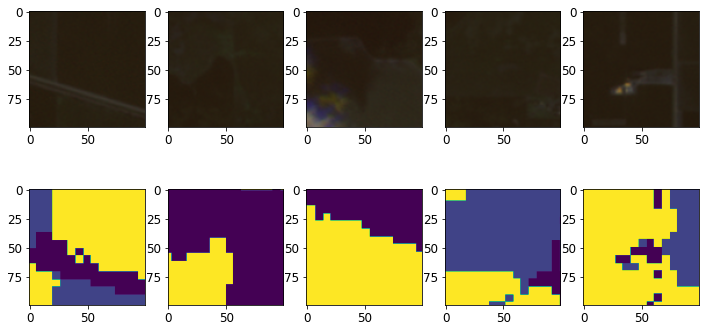

In [40]:
plt.figure(figsize=(12, 6))
chunk_indicies = np.random.randint(0, all_training_chunks.shape[0], 5)

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt_rgb(
        all_training_chunks[chunk_indicies[i]],
        bit_depth=15,  # this effectively brings up the brightness, making it easier to discern detail
    )

    plt.subplot(2, 5, i + 6)
    plt.imshow(training_data_labels_chunked[chunk_indicies[i]])

plt.show()
